In [1]:
import numpy as np
import seaborn as sns
from matplotlib import font_manager
from utils import galmen_rubin, KLdivergence
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
# from bioinfokit.analys import stat
import pingouin as pg
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import emcee
from numpy.linalg import norm
# sns.set()

# MLP models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import pickle
import seaborn as sns
from scipy.stats import multivariate_normal
from pomegranate.distributions import *

In [3]:
# Effective Sample Size
# load the mcmcp samples
trace_vgmcp = np.load('secondary-data/samples_vgmcp.npy', allow_pickle='TRUE').item()
trace_vae = np.load('secondary-data/samples_vae.npy', allow_pickle='TRUE').item()

In [4]:
for pid in [4, 5, 7, 8, 9, 11, 13, 15, 17, 19]:
    for emo in ['happy', 'sad', 'neutral']:
        chain1 = trace_vgmcp[f'subject_{pid}_{emo}_1']
        chain2 = trace_vgmcp[f'subject_{pid}_{emo}_2']

for pid in [1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28]:
    for emo in ['happy', 'sad', 'neutral']:
        chain1 = trace_vgmcp[f'study2_subject_{pid}_{emo}_1']
        chain2 = trace_vgmcp[f'study2_subject_{pid}_{emo}_2']

In [5]:
def batch_mean(x, nbatches):
    batch_indices = np.array_split(np.arange(len(x)), nbatches)
    batch_means = [np.mean(x[indices]) for indices in batch_indices]
    return np.var(batch_means) * len(x) / (nbatches - 1)

nbatches = 10
flat_samples = np.array(trace_vae['subject_1_sad_1']+trace_vae['subject_1_sad_2'])
batch_means_x = batch_mean(flat_samples[:, 0], nbatches)
batch_means_y = batch_mean(flat_samples[:, 1], nbatches)
batch_means_z = batch_mean(flat_samples[:, 2], nbatches)

# Calculate the effective sample size for each parameter
N = len(flat_samples)
N_eff_x = N / batch_means_x
N_eff_y = N / batch_means_y
N_eff_z = N / batch_means_z
N_eff_3D = min(N_eff_x, N_eff_y, N_eff_z)
N_eff_3D

0.051187125234733906

In [6]:
## mean representational faces
all_faces = {}
for method in ['pca', 'vae', 'vgmcp']:
    for emo in ['happy', 'sad', 'neutral']:
        all_faces[f'{method}_{emo}'] = []
for method in ['pca', 'vae', 'vgmcp']:
    for emo in ['happy', 'sad', 'neutral']:
        paths = [os.path.join(f'images/{method}/{emo}', i) for i in os.listdir(f'images/{method}/{emo}/') if '_' not in i]
        for path in paths:
            im_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            all_faces[f'{method}_{emo}'].append(im_gray)

all_faces.keys()

dict_keys(['pca_happy', 'pca_sad', 'pca_neutral', 'vae_happy', 'vae_sad', 'vae_neutral', 'vgmcp_happy', 'vgmcp_sad', 'vgmcp_neutral'])

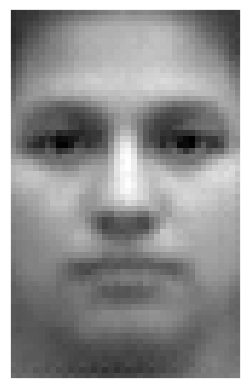

In [14]:
plt.imshow(np.mean(all_faces['vgmcp_neutral'], axis=0), cmap='gray')
plt.grid(None)
# plt.axis(None)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

## R_hat comparison

In [2]:
rhat_pca = np.load("secondary-data/rhat_pca.npy")
rhat_vae = np.load("secondary-data/rhat_vae.npy")
rhat_vgmcp = np.load("secondary-data/rhat_vgmcp.npy")

rhat_vgmcp_t = np.load("secondary-data/rhat_vgmcp_t.npy")
rhat_vae_t = np.load("secondary-data/rhat_vae_t.npy")
rhat_pca_t = np.load("secondary-data/rhat_pca_t.npy")

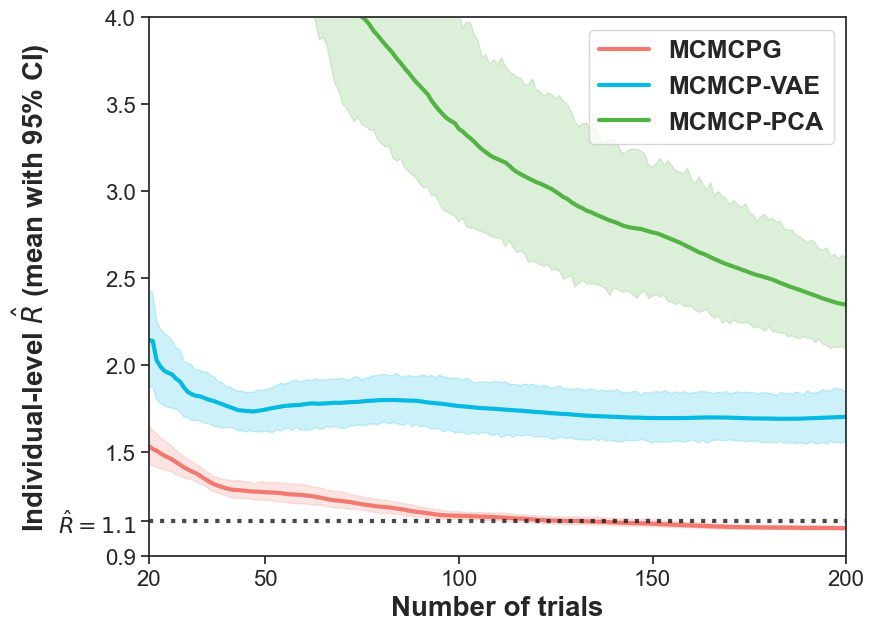

In [12]:
# Rhat trend along the time axis
# ticks_font = font_manager.FontProperties(family='Arial', size=18)
# plt.rc('lines', linewidth=1.5)
sns.set_style(style='ticks') 
fig, ax = plt.subplots(figsize=(9,7))

r_hats_vgmcp = np.zeros((23, 3, 200))
for i in range(23):
    for j in range(3):
        for k in range(500, len(rhat_vgmcp_t[i, j, :])):
            if rhat_vgmcp_t[i, j, :][k] == 0:
                break
        index = np.linspace(0, k-1, 200, dtype = int)
        r_hats_vgmcp[i, j, :] = rhat_vgmcp_t[i, j, :][index]

r_hats_vae = np.zeros((18, 3, 200))
for i in range(18):
    for j in range(3):
        for k in range(50, len(rhat_vae_t[i, j, :])):
            if rhat_vae_t[i, j, :][k] == 0:
                break
        index = np.linspace(0, k-1, 200, dtype = int)
        r_hats_vae[i, j, :] = rhat_vae_t[i, j, :][index]

r_hats_pca = np.zeros((18, 3, 200))
for i in range(18):
    for j in range(3):
        for k in range(50, len(rhat_pca_t[i, j, :])):
            if rhat_pca_t[i, j, :][k] == 0:
                break
        index = np.linspace(0, k-1, 200, dtype = int)
        r_hats_pca[i, j, :] = rhat_pca_t[i, j, :][index]

alp = 1
c1 = '#F27970'
c2 = '#05B9E2'
c3 = '#54B345'

sns.lineplot(x=np.repeat(np.arange(1, 201).reshape((1, -1)), 23, axis=0).reshape((-1)), 
             y=np.mean(r_hats_vgmcp, axis=1).reshape((-1)), errorbar=('ci'), label='MCMCPG', color=c1, alpha=alp, linewidth=3)
sns.lineplot(x=np.repeat(np.arange(1, 201).reshape((1, -1)), 18, axis=0).reshape((-1)), 
             y=np.mean(r_hats_vae, axis=1).reshape((-1)), errorbar=('ci'), label='MCMCP-VAE', color=c2, alpha=alp, linewidth=3)
sns.lineplot(x=np.repeat(np.arange(1, 201).reshape((1, -1)), 18, axis=0).reshape((-1)), 
             y=np.mean(r_hats_pca, axis=1).reshape((-1)), errorbar=('ci'), label='MCMCP-PCA', alpha=alp, color=c3, linewidth=3)

plt.axhline(y=1.1, linestyle='dotted', c='k', alpha=0.8, linewidth=3) 
ax.set_ylim(0.9, 4)
ax.set_xlim(20, 200)

ax.set_xlabel('Number of trials', fontdict={'fontsize': 20, 'family':'Arial', 'weight':'bold'})
ax.set_ylabel('Individual-level $\hat{R}$ (mean with 95% CI)', fontdict={'fontsize': 20, 'family':'Arial', 'weight':'bold'})
# ax.set_title('Accumulative Gelman-Rubin $\hat{R}$', fontdict={'fontsize': 16, 'family':'Arial'})

ax.legend(prop={'family':'Arial', 'size':18, 'weight':'bold'}, fancybox=True)

ax.xaxis.set_ticks([20, 50, 100, 150, 200])   
ax.set_xticklabels([20, 50, 100, 150, 200], fontdict={'fontsize': 16, 'family':'Arial'})

ax.yaxis.set_ticks([0.9, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
yticklabel = ax.set_yticklabels([0.9, '$\hat{R}=1.1$', 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], fontdict={'fontsize': 16, 'family':'Arial'})

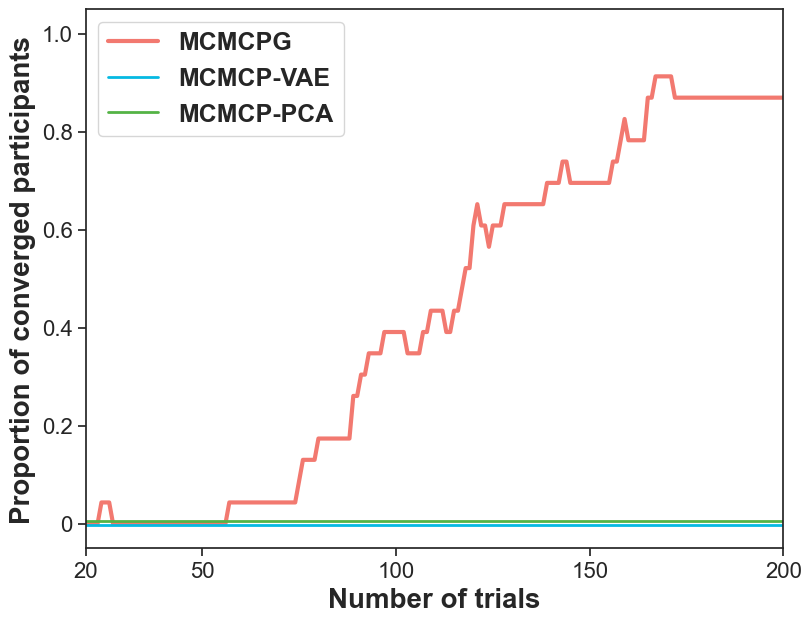

In [28]:
vgmcp_conv_ratio = []
mean_r_hats_vgmcp = np.mean(r_hats_vgmcp, axis=1)
for i in range(r_hats_vgmcp.shape[2]):
    vgmcp_conv_ratio.append(np.mean(mean_r_hats_vgmcp[:, i] < 1.1))

vae_conv_ratio = []
mean_r_hats_vae = np.mean(r_hats_vae, axis=1)
for i in range(r_hats_vae.shape[2]):
    vae_conv_ratio.append(np.mean(mean_r_hats_vae[:, i] < 1.1))

pca_conv_ratio = []
mean_r_hats_pca = np.mean(r_hats_pca, axis=1)
for i in range(r_hats_pca.shape[2]):
    pca_conv_ratio.append(np.mean(mean_r_hats_pca[:, i] < 1.1))

# ticks_font = font_manager.FontProperties(family='Times New Roman')
fig, ax = plt.subplots(figsize=(9,7))
# sns.lineplot(x=np.arange(1, 201), y=vgmcp_conv_ratio[0, :], label='VGMCP-happy', color='purple')
# sns.lineplot(x=np.arange(1, 201), y=vgmcp_conv_ratio[1, :], label='VGMCP-sad', color='green')
# sns.lineplot(x=np.arange(1, 201), y=vgmcp_conv_ratio[2, :], label='VGMCP-neutral', color='blue')
sns.lineplot(x=np.arange(1, 201), y=vgmcp_conv_ratio, label='MCMCPG', color=c1, linewidth=3)

# sns.lineplot(x=np.arange(1, 201), y=vae_conv_ratio[0, :], label='VAE-happy', color='purple', linestyle='--')
# sns.lineplot(x=np.arange(1, 201), y=vae_conv_ratio[1, :], label='VAE-sad', color='green', linestyle='--')
# sns.lineplot(x=np.arange(1, 201), y=vae_conv_ratio[2, :], label='VAE-neutral', color='blue', linestyle='--')
sns.lineplot(x=np.arange(1, 201), y=np.mean(vae_conv_ratio, axis=0)-0.012, label='MCMCP-VAE', color=c2, linewidth=2, alpha=1)

# sns.lineplot(x=np.arange(1, 201), y=pca_conv_ratio[0, :], label='PCA-happy', color='purple', linestyle='-.')
# sns.lineplot(x=np.arange(1, 201), y=pca_conv_ratio[1, :], label='PCA-sad', color='green', linestyle='-.')
# sns.lineplot(x=np.arange(1, 201), y=pca_conv_ratio[2, :], label='PCA-neutral', color='blue', linestyle='-.')
sns.lineplot(x=np.arange(1, 201), y=np.mean(pca_conv_ratio, axis=0)-0.003, label='MCMCP-PCA', color=c3, linewidth=2, alpha=1)

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(20, 200)

ax.set_xlabel('Number of trials', fontdict={'fontsize': 20, 'family':'Arial', 'weight':'bold'})
ax.set_ylabel('Proportion of converged participants', fontdict={'fontsize': 20, 'family':'Arial', 'weight':'bold'})
# ax.set_title('Trend of proportion of convergence along sampling', fontdict={'fontsize': 16, 'family':'Arial'})

ax.legend(prop={'family':'Arial', 'size':18, 'weight':'bold'}, fancybox=True)

ax.xaxis.set_ticks([20, 50, 100, 150, 200])   
ax.set_xticklabels([20, 50, 100, 150, 200], fontdict={'fontsize': 16, 'family':'Arial'})

ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
yticklabel = ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={'fontsize': 16, 'family':'Arial'})

In [20]:
col_names = ['group', 'emotion', 'rhat']
values = []
for i, data in enumerate([rhat_pca, rhat_vae, rhat_vgmcp]): 
    for j, emo in enumerate(['happy', 'sad', 'neutral']):
        for rhat in data[:, j]:
            method = ['pca', 'vae', 'vae-guided'][i]
            row_data = [method, emo, rhat]
            values.append(row_data)
rhats = pd.DataFrame(values, columns=col_names)

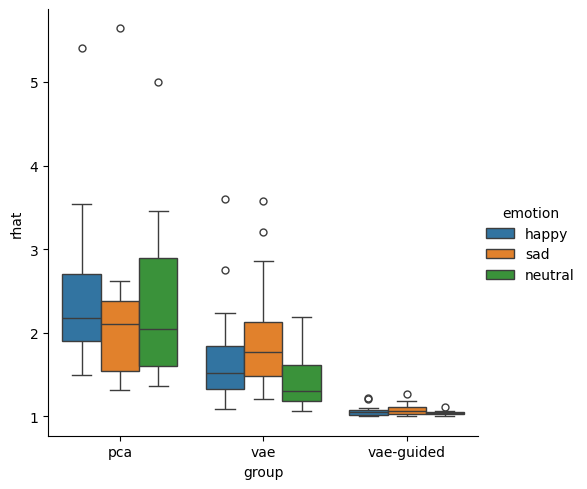

In [21]:
sns.catplot(data=rhats, x="group", y="rhat", hue="emotion", kind="box")

(0.8, 4.0)

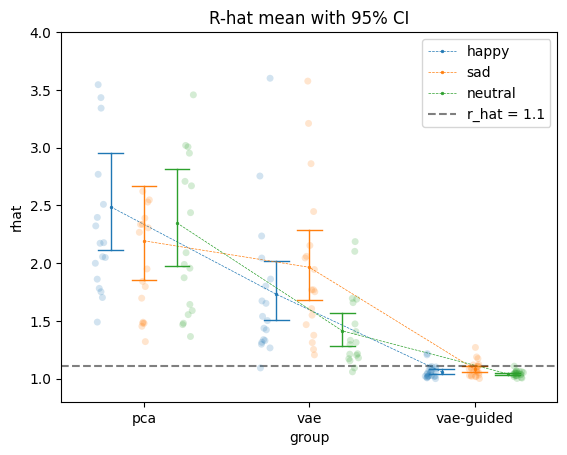

In [230]:
sns.stripplot(
    data=rhats, x="group", y="rhat", hue="emotion",
    dodge=.4, alpha=.2, legend=False,
)
sns.pointplot(data=rhats, x="group", y="rhat", hue="emotion", errorbar=('ci', 95), 
              capsize=.15, linestyle="--", linewidth=0.5, dodge=.4, markersize=2, err_kws={'linewidth': 1.0})
plt.axhline(y=1.11, linestyle='--', c='k', alpha=0.5, label='r_hat = 1.1') 
plt.legend()
plt.title('R-hat mean with 95% CI')
plt.ylim(0.8, 4)

## subjective rating

In [29]:
data_path = 'MCMCP-rating'
csv_names = os.listdir(data_path)

In [30]:
col_names = ['img_id']
ids = [i for i in range(1, 184)]
ratings = pd.DataFrame(ids, columns=col_names)

emotions = []
methods = []
for i in ids:
    if 19<=i<=36 or 73<=i<=90 or 132<=i<=154 or 178<=i<=180:
        emotions.append('happy')
        if 19<=i<=36:
            methods.append('pca')
        elif 73<=i<=90:
            methods.append('vae')
        elif 132<=i<=154:
            methods.append('vgmcp')
        elif i == 178:
            methods.append('g6')
        elif i == 179:
            methods.append('u16')
        elif i == 180:
            methods.append('u6')
    elif 1<=i<=18 or 55<=i<=72 or 109<=i<=131:
        emotions.append('neutral')
        if 1<=i<=18:
            methods.append('pca')
        elif 55<=i<=72:
            methods.append('vae')
        elif 109<=i<=131:
            methods.append('vgmcp')
    elif 37<=i<=54 or 91<=i<=108 or 155<=i<=177 or 181<=i<=183:
        emotions.append('sad')
        if 37<=i<=54:
            methods.append('pca')
        elif 91<=i<=108:
            methods.append('vae')
        elif 155<=i<=177:
            methods.append('vgmcp')
        elif i == 181:
            methods.append('g6')
        elif i == 182:
            methods.append('u16')
        elif i == 183:
            methods.append('u6')

ratings['emotion'] = emotions
ratings['method'] = methods

for i, csv in enumerate(csv_names):
    table = pd.read_csv(os.path.join(data_path, csv))[['rating', 'img_id']]
    table = table.dropna().sort_values(by=['img_id']).reset_index(drop=True)
    ratings[f'rating{i+1}'] = table['rating']

ratings = ratings.drop(["rating9"], axis='columns')
ratings['ave_rating'] = ratings.iloc[:, 3:].mean(axis=1)
ratings['std_rating'] = ratings.iloc[:, 3:-1].std(axis=1)
ratings['cv_rating'] = ratings.iloc[:, 3:-2].std(axis=1) / ratings.iloc[:, 3:-2].mean(axis=1)

In [31]:
ratings[-6:]

,img_id,emotion,method,rating1,rating2,rating3,rating4,rating5,rating6,rating7,...,rating22,rating23,rating24,rating25,rating26,rating27,rating28,ave_rating,std_rating,cv_rating
177,178,happy,g6,7.0,8.0,7.0,7.0,7.0,9.0,9.0,...,8.0,7.0,7.0,8.0,6.0,9.0,8.0,7.629630,0.926040,0.121374
178,179,happy,u16,9.0,7.0,6.0,7.0,8.0,8.0,9.0,...,7.0,7.0,7.0,7.0,7.0,9.0,8.0,7.629630,0.966681,0.126701
179,180,happy,u6,8.0,6.0,4.0,6.0,8.0,9.0,9.0,...,7.0,7.0,8.0,8.0,6.0,9.0,8.0,7.518519,1.188741,0.158108
180,181,sad,g6,2.0,1.0,6.0,2.0,1.0,5.0,7.0,...,4.0,4.0,6.0,2.0,1.0,5.0,3.0,3.111111,2.136376,0.686692
181,182,sad,u16,5.0,5.0,3.0,3.0,1.0,5.0,4.0,...,4.0,6.0,6.0,3.0,1.0,9.0,5.0,3.518519,2.100739,0.597052
182,183,sad,u6,5.0,1.0,3.0,7.0,2.0,5.0,8.0,...,4.0,6.0,6.0,7.0,1.0,8.0,6.0,3.777778,2.485857,0.658021


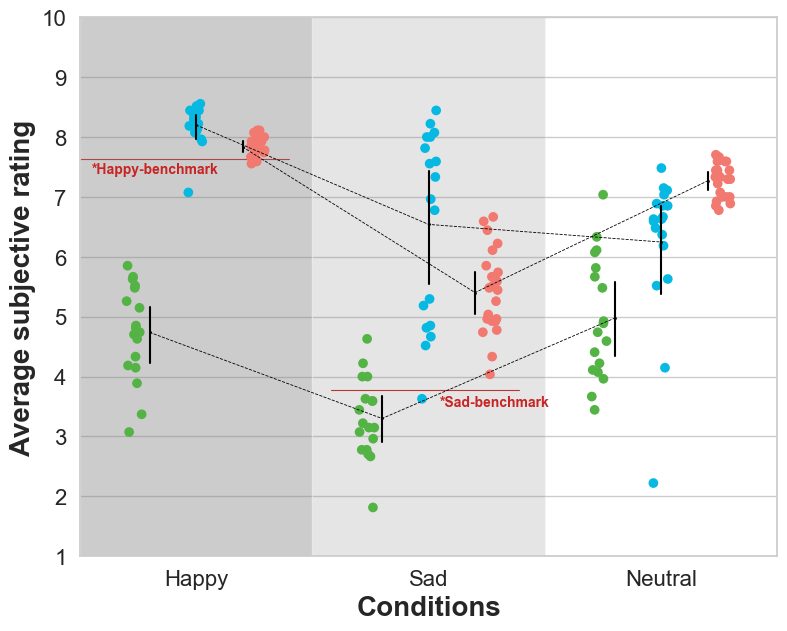

In [89]:
sns.set_style(style='whitegrid') 
fig, ax = plt.subplots(figsize=(9,7))

ax = sns.stripplot(
    data=ratings.iloc[:-6], x="emotion", y="ave_rating", hue="method", legend=False, size=7, 
    dodge=0.3, alpha=1, order=['happy', 'sad', 'neutral'], hue_order=['pca', 'vae', 'vgmcp'], palette=sns.color_palette([c3, c2, c1]), edgecolor="k", linewidth=0)

ax = sns.pointplot(data=ratings.iloc[:-6], x="emotion", y="ave_rating", hue="method", errorbar=('ci', 99), 
              capsize=0, linestyle="--", linewidth=0.6, markersize=1.5, dodge=0.4, err_kws={'linewidth': 1.5}, legend=False, 
              order=['happy', 'sad', 'neutral'], hue_order=['pca', 'vae', 'vgmcp'], palette=sns.color_palette(["#000000", "#000000", "#000000"]), zorder=100)

# ax.legend(prop={'family':'Times New Roman', 'size':14}, loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)

ax.set_ylim(1, 10)
# ax.legend(prop={'family':'Arial', 'size':16}, fancybox=True, labels=['MCMCP-PCA', 'MCMCP-VAE', 'MCMCPG'], ncol=1)
ax.set_xlabel('Conditions', fontdict={'fontsize': 20, 'family':'Arial', 'weight': 'bold'})
ax.set_ylabel('Average subjective rating', fontdict={'fontsize': 20, 'family':'Arial', 'weight': 'bold'})
# ax.set_title('Subjective ratings of preferred expressions', fontdict={'fontsize': 16, 'family':'Arial'})

ax.xaxis.set_ticks([0, 1, 2])   
ax.set_xticklabels(['Happy', 'Sad', 'Neutral'], fontdict={'fontsize': 16, 'family':'Arial'})

ax.yaxis.set_ticks(np.arange(1, 11))
ax.set_yticklabels(np.arange(1, 11), fontdict={'fontsize': 16, 'family':'Arial'})

ax.text(-0.45, 7.4, '*Happy-benchmark', color='#c82423', verticalalignment='baseline', fontdict={'fontsize': 10, 'family':'Arial', 'weight': 'heavy'})
ax.axhline(y=7.63, xmin=0, xmax=0.3, c="#c82423", ls='-', linewidth=0.8, zorder=0, clip_on=False)
ax.text(1.05, 3.5, '*Sad-benchmark', color='#c82423', verticalalignment='baseline', fontdict={'fontsize': 10, 'family':'Arial', 'weight': 'heavy'})
ax.axhline(y=3.78, xmin=0.36, xmax=0.63, c="#c82423", ls='-', linewidth=0.8, zorder=0, clip_on=False)

ax.set_xlim(-0.5, 2.5)
ax.axvspan(-0.5, 0.5, facecolor='gray', alpha=0.4)
ax.axvspan(0.5, 1.5, facecolor='gray', alpha=0.2)
ax.axvspan(1.5, 2.5, facecolor='gray', alpha=0)

In [72]:
method = 'vgmcp'
emo = 'neutral'
print(ratings[(ratings['method']==method)&(ratings['emotion']==emo)]["ave_rating"].mean(), 
      '+-', 
      ratings[(ratings['method']==method)&(ratings['emotion']==emo)]["ave_rating"].std() * 1.96 / np.sqrt(len(ratings[(ratings['method']==method)&(ratings['emotion']==emo)])))

7.26731078904992 +- 0.11390975427934862


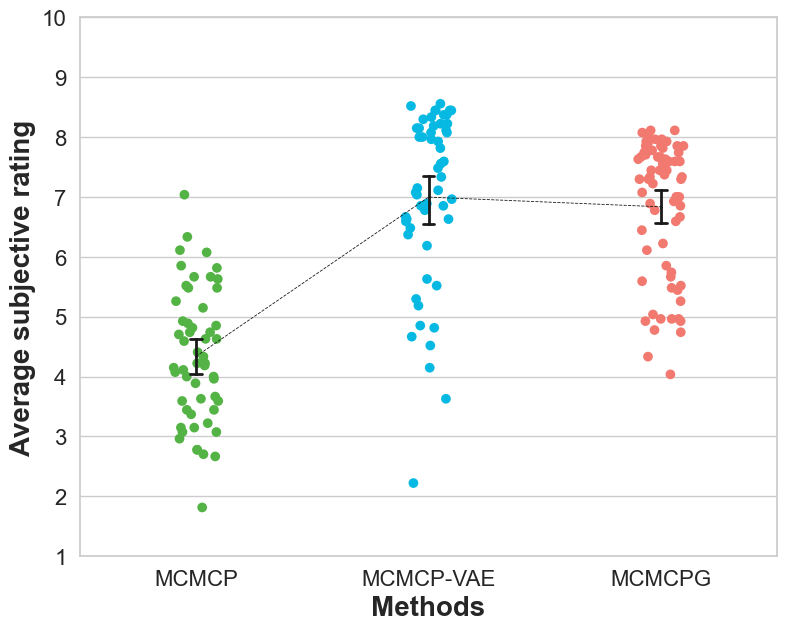

In [87]:
fig, ax = plt.subplots(figsize=(9,7))

ax = sns.stripplot(
    data=ratings.iloc[:-6], x="method", y="ave_rating",  size=7, 
    dodge=0, alpha=1, legend=False, order=['pca', 'vae', 'vgmcp'], hue="method", palette=sns.color_palette([c3, c2, c1])
)

ax = sns.pointplot(data=ratings.iloc[:-6], x="method", y="ave_rating", errorbar=('ci', 95), 
              capsize=0.05, linestyle="--", linewidth=0.6, err_kws={'linewidth': 2.0}, c='k', zorder=100)
# ax.legend(prop={'family':'Times New Roman', 'size':14}, loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)
ax.set_ylim(1, 10)

ax.set_xlabel('Methods', fontdict={'fontsize': 20, 'family':'Arial', 'weight': 'bold'})
ax.set_ylabel('Average subjective rating', fontdict={'fontsize': 20, 'family':'Arial', 'weight': 'bold'})
# ax.set_title('Subjective ratings of preferred expressions', fontdict={'fontsize': 16, 'family':'Arial'})

ax.xaxis.set_ticks([0, 1, 2])   
ax.set_xticklabels(['MCMCP', 'MCMCP-VAE', 'MCMCPG'], fontdict={'fontsize': 16, 'family':'Arial'})

ax.yaxis.set_ticks(np.arange(1, 11))
info = ax.set_yticklabels(np.arange(1, 11), fontdict={'fontsize': 16, 'family':'Arial'})

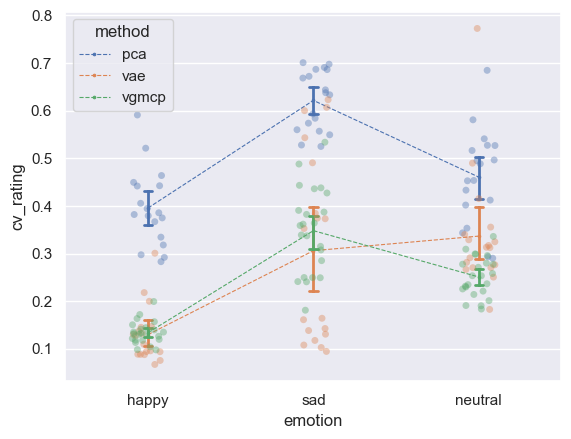

In [131]:
sns.stripplot(
    data=ratings.iloc[:-6], x="emotion", y="cv_rating", hue="method",
    dodge=0, alpha=.4, legend=False, order=['happy', 'sad', 'neutral'], hue_order=['pca', 'vae', 'vgmcp']
)

ax = sns.pointplot(data=ratings.iloc[:-6], x="emotion", y="cv_rating", errorbar=('ci', 95), hue="method",
              capsize=0.05, linestyle="--", linewidth=0.8, err_kws={'linewidth': 2.0}, order=['happy', 'sad', 'neutral'], hue_order=['pca', 'vae', 'vgmcp'])

#### Anova

In [74]:
ratings_anova = ratings.iloc[:-6]

In [13]:
ols_formula = 'ave_rating ~ C(method)'
OLS = ols(formula = ols_formula, data = ratings_anova)
model = OLS.fit()
# model_results = model.summary()
# model_results
print(sm.stats.anova_lm(model, typ=2))

tukey_oneway = pairwise_tukeyhsd(endog = ratings_anova["ave_rating"], 
                                 groups = ratings_anova["method"], 
                                 alpha=0.05)
print(tukey_oneway.summary())

               sum_sq     df          F        PR(>F)
C(method)  248.186195    2.0  81.451836  1.083390e-25
Residual   265.091617  174.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   pca    vae   2.6584    0.0 2.0969   3.22   True
   pca  vgmcp   2.4965    0.0 1.9664 3.0267   True
   vae  vgmcp  -0.1619 0.7509 -0.692 0.3682  False
--------------------------------------------------


In [15]:
# Define the OLS formula.
emo = 'neutral'
ols_formula = 'ave_rating ~ C(method) + C(emotion) + C(method)*C(emotion)'
OLS = ols(formula = ols_formula, data = ratings_anova)
model = OLS.fit()
# model_results = model.summary()
# model_results
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(method),248.186195,2.0,172.191663,2.089299e-41
C(emotion),107.340494,2.0,74.472870,6.970220e-24
C(method):C(emotion),36.678825,4.0,12.723890,4.554947e-09
Residual,121.072298,168.0,NaN,NaN


In [78]:
emo = 'happy'
tukey_oneway = pairwise_tukeyhsd(endog = ratings_anova[ratings_anova['emotion']==emo]["ave_rating"], 
                                 groups = ratings_anova[ratings_anova['emotion']==emo]["method"], 
                                 alpha=0.05)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
pca,vae,3.463,0.0,3.073,3.8529,True
pca,vgmcp,3.0955,0.0,2.7273,3.4636,True
vae,vgmcp,-0.3675,0.0505,-0.7356,0.0006,False


In [52]:
# Define the OLS formula.
ols_formula = 'cv_rating ~ C(emotion)'
OLS = ols(formula = ols_formula, data = ratings_anova)
model = OLS.fit()
# model_results = model.summary()
# model_results
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(emotion),1.277723,2.0,27.91144,3.065991e-11
Residual,3.982664,174.0,NaN,NaN


In [53]:
tukey_oneway = pairwise_tukeyhsd(endog = ratings_anova["cv_rating"], 
                                 groups = ratings_anova["emotion"], 
                                 alpha=0.05)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
happy,neutral,0.1284,0.0,0.0625,0.1942,True
happy,sad,0.206,0.0,0.1402,0.2719,True
neutral,sad,0.0777,0.0162,0.0118,0.1435,True


#### T-test

In [62]:
emo = 'happy'  # 'happy'
data = ratings_anova[(ratings_anova['emotion']==emo) & (ratings_anova['method']=='vgmcp')]['ave_rating']
if emo == 'sad':
    print('  g6:', stats.ttest_1samp(data, popmean=ratings.iloc[-3, -1]), '\n',
          'u16:', stats.ttest_1samp(data, popmean=ratings.iloc[-2, -1]), '\n',
          ' u6-Benchmark:', stats.ttest_1samp(data, popmean=ratings.iloc[-1, -1]))
elif emo == 'happy':
    print('  g6:', stats.ttest_1samp(data, popmean=ratings.iloc[-6, -1]), '\n',
          'u16-Benchmark:', stats.ttest_1samp(data, popmean=ratings.iloc[-5, -1]), '\n',
          ' u6:', stats.ttest_1samp(data, popmean=ratings.iloc[-4, -1]))

  g6: TtestResult(statistic=5.991681134429011, pvalue=4.968732085680521e-06, df=22) 
 u16-Benchmark: TtestResult(statistic=5.991681134429011, pvalue=4.968732085680521e-06, df=22) 
  u6: TtestResult(statistic=9.247003955496798, pvalue=4.918210558029287e-09, df=22)


#### Coefficient of Variation

In [160]:
cv_happy = ratings_anova[(ratings_anova['emotion']=='happy') & (ratings_anova['method']=='pca')]['ave_rating']
cv_sad = ratings_anova[(ratings_anova['emotion']=='sad') & (ratings_anova['method']=='pca')]['ave_rating']
cv_neutral = ratings_anova[(ratings_anova['emotion']=='neutral') & (ratings_anova['method']=='pca')]['ave_rating']
print('\n cv of happy:', cv_happy.std()/cv_happy.mean(), 
      '\n cv of sad:', cv_sad.std()/cv_sad.mean(), 
      '\n cv of neutral:', cv_neutral.std()/cv_neutral.mean())


 cv of happy: 0.16749222462133947 
 cv of sad: 0.20290571032338986 
 cv of neutral: 0.20550728302537563


<Axes: xlabel='emotion', ylabel='cv_rating'>

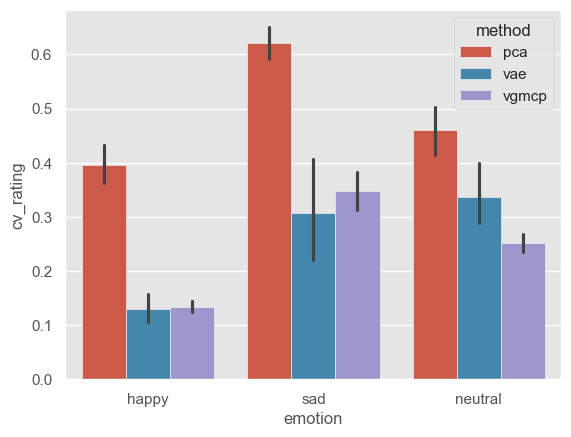

In [162]:
sns.barplot(ratings_anova, x="emotion", y="cv_rating", hue="method", order=['happy', 'sad', 'neutral']) 

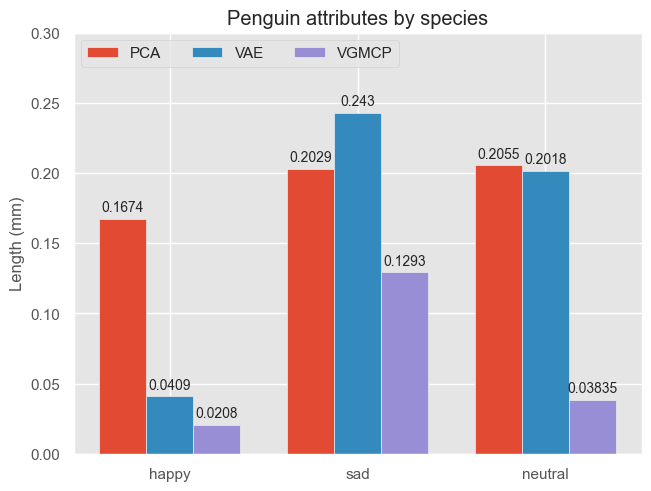

In [161]:
# fig, ax = plt.subplots(figsize=(6, 6))
# fruits = ['happy', 'sad', 'neutral']
# counts = [cv_happy.std()/cv_happy.mean(), cv_sad.std()/cv_sad.mean(), cv_neutral.std()/cv_neutral.mean()]
# bar_colors = ['tab:purple', 'tab:green', 'tab:blue']

# ax.bar(fruits, counts, color=bar_colors, width=0.5)
# # ax.plot(1, 0.14, "*", markersize=10, color="r")
# ax.set_ylabel('Coefficient of Variation')
# # ax.set_title('Coefficient of Variation for each emotion recovered by VGMCP')
# plt.show()

species = ("happy", "sad", "neutral")
penguin_means = {
    'PCA': (0.1674, 0.2029, 0.2055),
    'VAE': (0.0409, 0.2430, 0.2018),
    'VGMCP': (0.0208, 0.1293, 0.03835),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.3)

plt.show()

#### heatmap

In [520]:
ratings_map = ratings
# ratings_map.columns = ratings_map.columns[:3].tolist() + [f"s{i+1}" for i in range(27)] + [ratings_anova.columns[-1]]

In [548]:
target = 'neutral'
matrix = ratings_map[(ratings_map['emotion']==target) & (ratings_map['method']=='vgmcp')].reset_index(drop=True).iloc[:, 3:-3].values

In [549]:
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

# Assuming you have your data matrix in a numpy array called 'data_matrix'
# data_matrix should be of shape (n_samples, n_features)

best_score = -1
best_n_clusters_rows = None
best_n_clusters_cols = None

# Iterate over possible numbers of clusters for rows
for n_clusters_rows in range(2, 8):
    # Iterate over possible numbers of clusters for columns
    for n_clusters_cols in range(2, 8):
        # Create a Spectral Biclustering model
        model = SpectralBiclustering(n_clusters=(n_clusters_rows, n_clusters_cols), method='log')

        # Fit the model to the data
        model.fit(matrix)

        # Get row and column labels
        row_labels = model.row_labels_
        col_labels = model.column_labels_

        # Compute silhouette score
        silhouette_avg = silhouette_score(matrix, row_labels)

        # Compute Calinski-Harabasz score
        ch_score = calinski_harabasz_score(matrix, row_labels)

        # Update best_score and best_n_clusters if the current scores are higher
        if ch_score > best_score:
            best_score = ch_score
            best_n_clusters_rows = n_clusters_rows
            best_n_clusters_cols = n_clusters_cols

print(best_n_clusters_rows, best_n_clusters_cols)
# Create a Spectral Biclustering model with the best number of clusters for rows and columns
best_model = SpectralBiclustering(n_clusters=(best_n_clusters_rows, best_n_clusters_cols), method='log')

# Fit the best model to the data
best_model.fit(matrix)

# Get row and column labels from the best model
best_row_labels = best_model.row_labels_
best_col_labels = best_model.column_labels_

# Reorder the data matrix based on the bicluster labels
ordered_data = matrix[np.argsort(best_row_labels)]
ordered_data = ordered_data[:, np.argsort(best_col_labels)]

2 3


[Text(0, 0.5, '1'),
 Text(0, 1.5, '21'),
 Text(0, 2.5, '20'),
 Text(0, 3.5, '18'),
 Text(0, 4.5, '17'),
 Text(0, 5.5, '16'),
 Text(0, 6.5, '15'),
 Text(0, 7.5, '11'),
 Text(0, 8.5, '10'),
 Text(0, 9.5, '12'),
 Text(0, 10.5, '8'),
 Text(0, 11.5, '6'),
 Text(0, 12.5, '5'),
 Text(0, 13.5, '4'),
 Text(0, 14.5, '9'),
 Text(0, 15.5, '23'),
 Text(0, 16.5, '22'),
 Text(0, 17.5, '13'),
 Text(0, 18.5, '14'),
 Text(0, 19.5, '7'),
 Text(0, 20.5, '19'),
 Text(0, 21.5, '3'),
 Text(0, 22.5, '2')]

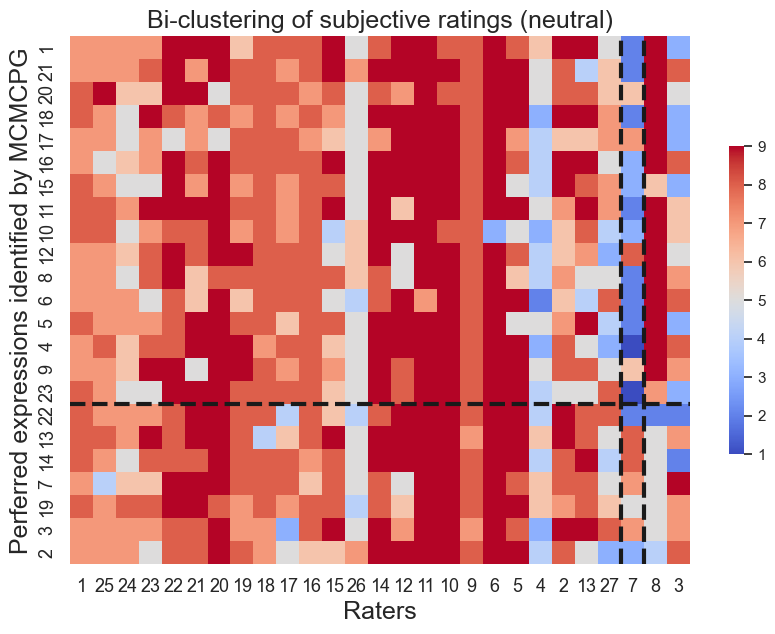

In [550]:
fig, ax = plt.subplots(figsize=(10,10))

yticks = [i+0.5 for i in range(len(matrix))]
yticklabels = [i+1 for i in np.argsort(best_row_labels)]
xticks = [i+0.5 for i in range(len(matrix[0]))]
xticklabels = [i+1 for i in np.argsort(best_col_labels)]

ax = sns.heatmap(ordered_data, 
                 cmap="coolwarm", 
                 square=True, cbar_kws={'shrink': 0.4}, yticklabels=yticklabels)
cols = np.unique(best_col_labels)
rows = np.unique(best_row_labels)
boundry = 0
for i in cols[:-1]:
    boundry += np.sum(best_col_labels == i)
    ax.axvline(x=boundry, color='k',linewidth=3, linestyle='--')

boundry = 0
for i in rows[:-1]:
    boundry += np.sum(best_row_labels == i)
    ax.axhline(y=boundry, color='k',linewidth=3, linestyle='--')
    
# ax.xaxis.tick_top()

ax.set_xlabel('Raters', fontdict={'fontsize': 18, 'family':'Arial'})
ax.set_ylabel('Perferred expressions identified by MCMCPG', fontdict={'fontsize': 18, 'family':'Arial'})
ax.set_title(f'Bi-clustering of subjective ratings ({target})', fontdict={'fontsize': 18, 'family':'Arial'})

ax.xaxis.set_ticks(xticks)   
ax.set_xticklabels(xticklabels, fontdict={'fontsize': 13, 'family':'Arial'})

ax.yaxis.set_ticks(yticks)
ax.set_yticklabels(yticklabels, fontdict={'fontsize': 13, 'family':'Arial'})

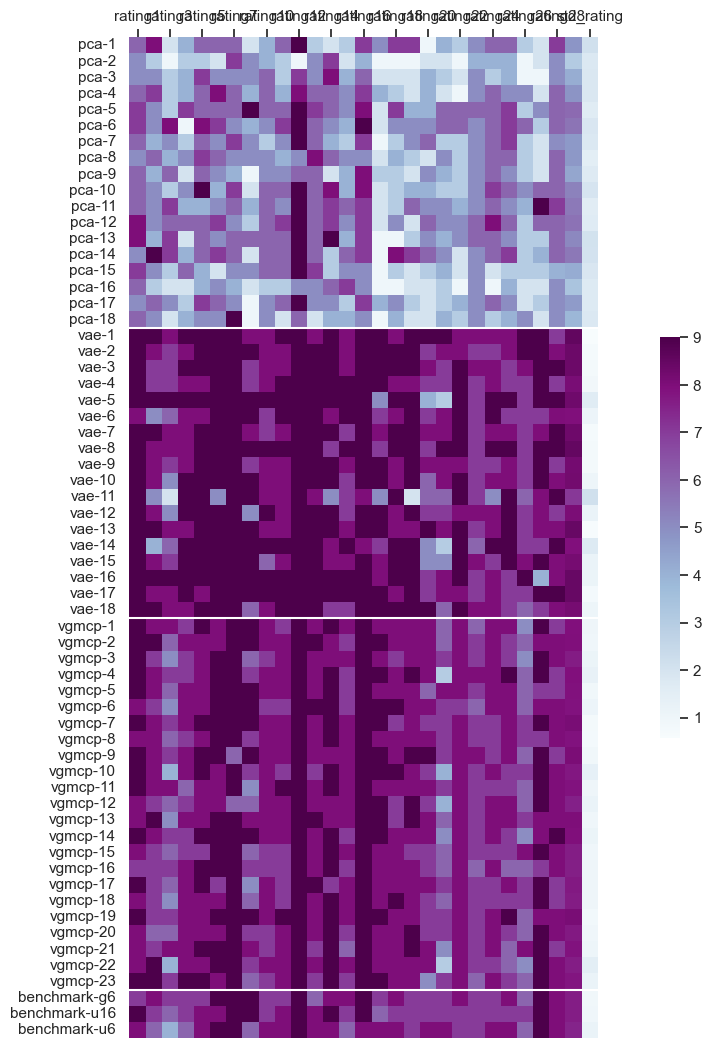

In [443]:
emo = 'happy'
matrix = ratings_map[(ratings_map['emotion']==emo)].reset_index(drop=True)
yticks = [i+0.5 for i in range(len(matrix))]
yticklabels = [f'pca-{i+1}' for i in range(18)] + [f'vae-{i+1}' for i in range(18)] + [f'vgmcp-{i+1}' for i in range(23)] + ['benchmark-g6', 'benchmark-u16', 'benchmark-u6']
plt.figure(figsize = (16,13))
ax = sns.heatmap(matrix.iloc[:, 3:-1], 
                 cmap="BuPu", 
                 square=True, cbar_kws={'shrink': 0.4}, xticklabels=2, yticklabels=yticklabels)
ax.set_yticks(yticks)
ax.xaxis.tick_top()
ax.axhline(y=18, color='w',linewidth=1.5)
ax.axhline(y=36, color='w',linewidth=1.5)
ax.axhline(y=59, color='w',linewidth=1.5)

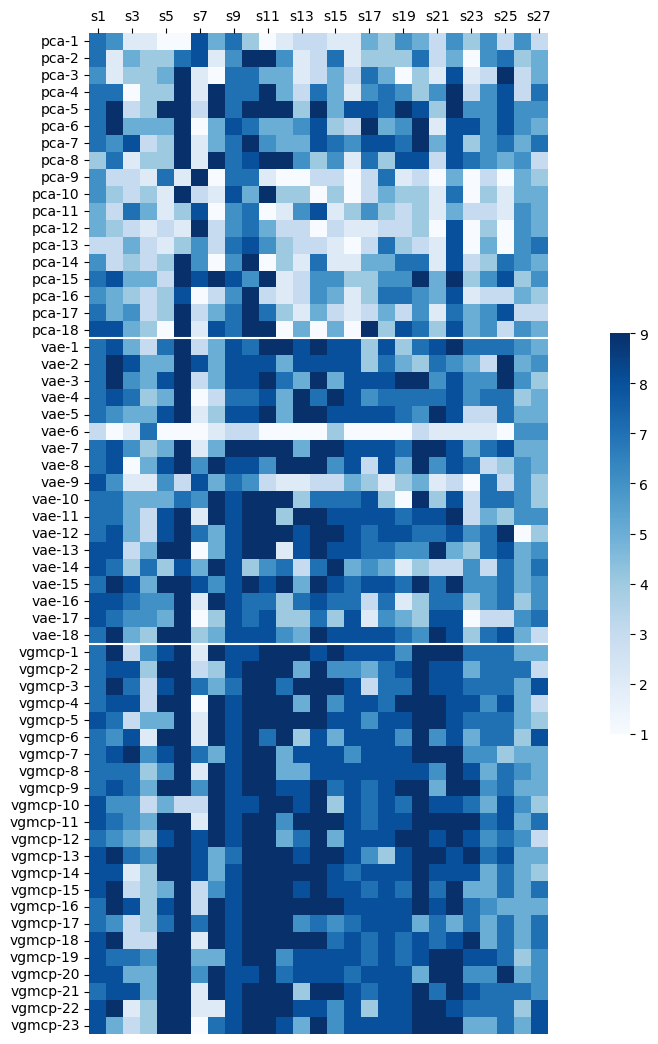

In [68]:
emo = 'neutral'
matrix = ratings_map[(ratings_map['emotion']==emo)].reset_index(drop=True)
yticks = [i+0.5 for i in range(len(matrix))]
yticklabels = [f'pca-{i+1}' for i in range(18)] + [f'vae-{i+1}' for i in range(18)] + [f'vgmcp-{i+1}' for i in range(23)]
plt.figure(figsize = (16,13))
ax = sns.heatmap(matrix.iloc[:, 3:-1], 
                 cmap="Blues", 
                 square=True, cbar_kws={'shrink': 0.4}, xticklabels=2, yticklabels=yticklabels)
ax.set_yticks(yticks)
ax.xaxis.tick_top()
ax.axhline(y=18, color='w',linewidth=1.5)
ax.axhline(y=36, color='w',linewidth=1.5)

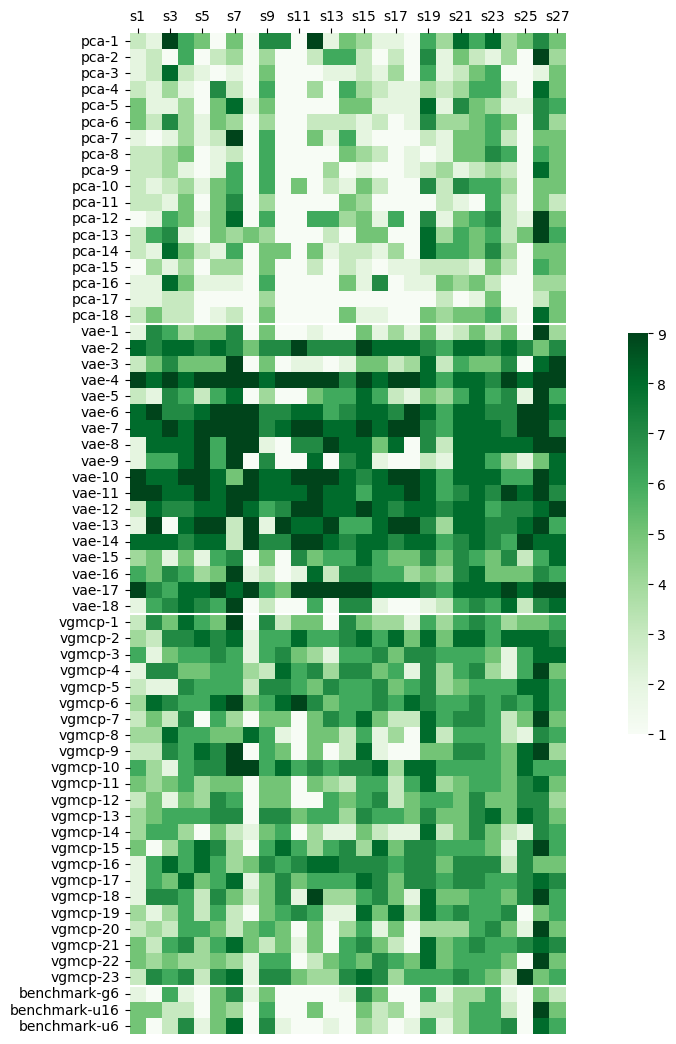

In [67]:
emo = 'sad'
matrix = ratings_map[(ratings_map['emotion']==emo)].reset_index(drop=True)
yticks = [i+0.5 for i in range(len(matrix))]
yticklabels = [f'pca-{i+1}' for i in range(18)] + [f'vae-{i+1}' for i in range(18)] + [f'vgmcp-{i+1}' for i in range(23)] + ['benchmark-g6', 'benchmark-u16', 'benchmark-u6']
plt.figure(figsize = (16,13))
ax = sns.heatmap(matrix.iloc[:, 3:-1], 
                 cmap="Greens", 
                 square=True, cbar_kws={'shrink': 0.4}, xticklabels=2, yticklabels=yticklabels)
ax.set_yticks(yticks)
ax.xaxis.tick_top()
ax.axhline(y=18, color='w',linewidth=1.5)
ax.axhline(y=36, color='w',linewidth=1.5)
ax.axhline(y=59, color='w',linewidth=1.5)

In [208]:
# ratings.to_csv('test.csv', encoding='utf-8', index=False)

#### rating distribution

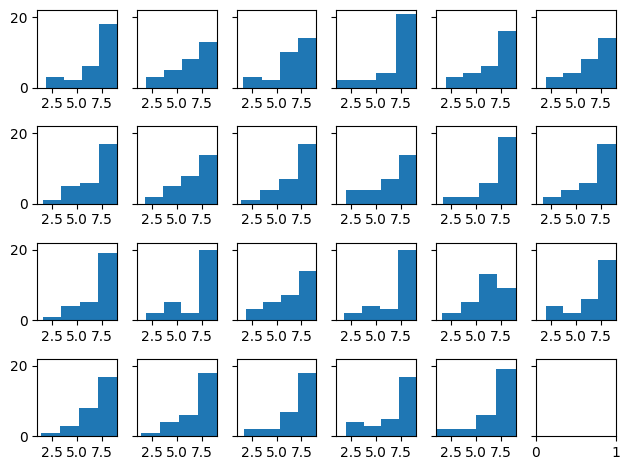

In [62]:
data_dist = ratings_anova[(ratings_anova['emotion']=='neutral') & (ratings_anova['method']=='vgmcp')]

fig, axs = plt.subplots(4, 6, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
for i in range(4):
    for j in range(6):
        try:
            axs[i, j].hist(data_dist.iloc[i*6+j, 3:-1], bins=4)
            axs[i, j].set_xlim(1, 9)
        except IndexError:
            continue

## Mapping data

In [2]:
data_path = 'MCMCP-mapping'
csv_names = os.listdir(data_path)

In [ ]:
mapping_dataset = []
for i, csv in enumerate(csv_names):
    table = pd.read_csv(os.path.join(data_path, csv))[['valence', 'arousal', 'img_id']].dropna().reset_index(drop=True).values
    for row in table.astype(int):
        maping_data = []
        maping_data.append(row[2])
        maping_data.append(row[0])
        maping_data.append(row[1])
        mapping_dataset.append(maping_data)

# mapping_dataset = np.array(mapping_dataset)

mapping_array = np.zeros((2200, 2))  # valence / arousal
for i in range(len(mapping_array)):
    if len(np.where(mapping_dataset[:, 0] == i+1)[0]) > 0:
        mapping_array[i, :] = np.mean(mapping_dataset[np.where(mapping_dataset[:, 0] == i+1)][:, 1:], axis=0)


mapping_loc = np.zeros((2200, 3))  # x/y/z
loc = 0
for i in [-8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8]:
    for j in [-8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8]:
        for k in [-8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8]:
            mapping_loc[loc, 0] = i
            mapping_loc[loc, 1] = j
            mapping_loc[loc, 2] = k
            loc += 1
mapping_loc[2197, :] = [8, 8, 4]
mapping_loc[2198, :] = [8, 8, 6]
mapping_loc[2199, :] = [8, 8, 8]
mapping_loc

mapping_loc = mapping_loc[np.where(mapping_array[:, 1]!=0)]
mapping_array = mapping_array[np.where(mapping_array[:, 1]!=0)]
len(mapping_loc)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def r_sigmoid(x):
    return -np.log((1-x)/x) + 5
        
model = nn.Sequential(
    nn.Linear(3, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
    nn.Sigmoid()
)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_index = np.random.choice(np.arange(0, 2152), replace=False, size=0)
train_index = [i for i in range(2152) if i not in test_index]

mapping_array_scale = (mapping_array-1) / 8  # 0-1

mapping_train_x, mapping_train_y = mapping_loc[train_index, :], mapping_array_scale[train_index, :]
mapping_test_x, mapping_test_y = mapping_loc[test_index, :], mapping_array_scale[test_index, :]
train_set = CustomDataset(mapping_train_x, mapping_train_y)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3000
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs.to(torch.float))
        batch_loss = loss(outputs, targets.to(torch.float))

        # Backward pass and optimization
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    # Print loss every 100 epochs
    if (epoch+1) % 50 == 0:
        outputs = model(torch.tensor(mapping_train_x, dtype=torch.float))
        valence_error = np.mean(np.abs(outputs[:, 0].detach().numpy() - mapping_train_y[:, 0]))
        arousal_error = np.mean(np.abs(outputs[:, 1].detach().numpy() - mapping_train_y[:, 1]))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {batch_loss.item():.4f}, Verror: {valence_error:.4f}, Aerror: {arousal_error:.4f}')

torch.save(model, 'savedmodel/mappingF_maxscaling.pt')
# model = torch.load('savedmodel/mappingF_maxscaling.pt')

In [3]:
model = torch.load('savedmodel/mappingF_maxscaling.pt')

In [4]:
# generate samples from individual's distributions and transfer them to the new space
with open("secondary-data/distribution_param", "rb") as fp:   # Unpickling
    distribution_param = pickle.load(fp)
len(distribution_param)

happy_means = np.zeros((23, 3))
happy_covs = np.zeros((23, 3, 3))
sad_means = np.zeros((23, 3))
sad_covs = np.zeros((23, 3, 3))
neutral_means = np.zeros((23, 3))
neutral_covs = np.zeros((23, 3, 3))

for i in range(len(distribution_param)):
    if i%3 == 0:
        happy_means[i//3, :] = distribution_param[i][0].numpy()
        happy_covs[i//3, :, :] = distribution_param[i][1].numpy()
    elif i%3 == 1:
        sad_means[i//3, :] = distribution_param[i][0].numpy()
        sad_covs[i//3, :, :] = distribution_param[i][1].numpy()
    elif i%3 == 2:
        neutral_means[i//3, :] = distribution_param[i][0].numpy()
        neutral_covs[i//3, :, :] = distribution_param[i][1].numpy()

# def get_samples(means, covs, n_samples):
#     all_samples = np.zeros((n_samples, 3, len(means)))
#     for i in range(len(means)):
#         all_samples[:, :, i] = np.random.multivariate_normal(means[i], covs[i], size=n_samples)
#     return all_samples

happy_va_mean = model(torch.tensor(happy_means, dtype=torch.float)).detach().cpu().numpy() *8 +1
sad_va_mean = model(torch.tensor(sad_means, dtype=torch.float)).detach().cpu().numpy() *8 +1
neutral_va_mean = model(torch.tensor(neutral_means, dtype=torch.float)).detach().cpu().numpy() *8 +1

In [4]:
# calculate the weights and density
def model_pdf(x, emotion):
    if emotion == "happy":
        covariance = np.array([[1.51, -0.21, -0.01], [-0.21, 1.10, 0.19], [0, 0.19, 1.14]])
        mean = np.array([3.0, -3.13, -2.78])
    elif emotion == "sad":
        covariance = np.array([[2.07, -0.38, -0.70], [-0.38, 1.17, -0.47], [-0.70, -0.47, 1.25]])
        mean = np.array([-0.69, 1.80, 1.78])
    else:
        covariance = np.array([[1.62, 0.43, -0.28], [0.43, 1.05, 0.02], [-0.28, 0.02, 1.21]])
        mean = np.array([1.70, 2.43, -0.48])

    dt = multivariate_normal(mean=mean, cov=covariance)

    return dt.pdf(x)

def weight_vae(x, emotion):
    weight = 1/np.sqrt(model_pdf(x, emotion))

    if weight <= 10000:
        return weight
    else:
        return 1

def weighted_cum(data, index, emo):
    if index == 0:
        index = len(data)
    weights = []
    for sample in data[:index]:
        weights.append(weight_vae(sample, emo))
    weights_sum = np.sum(weights)
    weighted_mean = np.zeros(3)
    for i in range(index):
        weighted_mean += np.array(data[i]) * weights[i]/weights_sum
    return weighted_mean, weights/weights_sum

In [5]:
# load the original sample data
trace_vgmcp = np.load('secondary-data/samples_vgmcp.npy', allow_pickle='TRUE').item()
trace_vae = np.load('secondary-data/samples_vae.npy', allow_pickle='TRUE').item()
happy_va_mean = []
sad_va_mean = []
neutral_va_mean = []
happy_va_cov = []
sad_va_cov = []
neutral_va_cov = []

all_va_samples = {}

for pid in [4, 5, 7, 8, 9, 11, 13, 15, 17, 19]:
    for emo in ['happy', 'sad', 'neutral']:
        all_sample = trace_vgmcp[f'subject_{pid}_{emo}_1'] + trace_vgmcp[f'subject_{pid}_{emo}_2']
        sample_va = model(torch.tensor(all_sample, dtype=torch.float)).detach().cpu().numpy() *8 +1
        all_va_samples[f'r1_{pid}_{emo}'] = sample_va
        weights = weighted_cum(all_sample, 0, emo)[1]
        dist = Normal().fit(np.array(sample_va).astype(np.float32), sample_weight=weights.astype(np.float32))
        if emo == 'happy':
            happy_va_mean.append(dist.means.tolist())
            happy_va_cov.append(dist.covs.tolist())
        elif emo == 'sad':
            sad_va_mean.append(dist.means.tolist())
            sad_va_cov.append(dist.covs.tolist())
        else:
            neutral_va_mean.append(dist.means.tolist())
            neutral_va_cov.append(dist.covs.tolist())
for pid in [1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28]:
    for emo in ['happy', 'sad', 'neutral']:
        all_sample = trace_vgmcp[f'study2_subject_{pid}_{emo}_1'] + trace_vgmcp[f'study2_subject_{pid}_{emo}_2']
        sample_va = model(torch.tensor(all_sample, dtype=torch.float)).detach().cpu().numpy() *8 +1
        all_va_samples[f'r2_{pid}_{emo}'] = sample_va
        weights = weighted_cum(all_sample, 0, emo)[1]
        dist = Normal().fit(np.array(sample_va).astype(np.float32), sample_weight=weights.astype(np.float32))
        if emo == 'happy':
            happy_va_mean.append(dist.means.tolist())
            happy_va_cov.append(dist.covs.tolist())
        elif emo == 'sad':
            sad_va_mean.append(dist.means.tolist())
            sad_va_cov.append(dist.covs.tolist())
        else:
            neutral_va_mean.append(dist.means.tolist())
            neutral_va_cov.append(dist.covs.tolist())
# model(torch.tensor([[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]])).detach().cpu().numpy()
happy_vae_mean = []
sad_vae_mean = []
neutral_vae_mean = []
for pid in [1, 6, 7, 11, 12, 13]:
    for emo in ['happy', 'sad', 'neutral']:
        all_sample = trace_vae[f'subject_{pid}_{emo}_1'] + trace_vae[f'subject_{pid}_{emo}_2']
        mean = np.mean(np.array(all_sample), axis=0).reshape(1, -1)
        sample_va = model(torch.tensor(mean, dtype=torch.float)).detach().cpu().numpy() *8 +1
        if emo == 'happy':
            happy_vae_mean.append(sample_va[0].tolist())
        elif emo == 'sad':
            sad_vae_mean.append(sample_va[0].tolist())
        else:
            neutral_vae_mean.append(sample_va[0].tolist())
for pid in [1, 3, 4, 7, 8, 9, 11, 12, 16, 19, 20, 22]:
    for emo in ['happy', 'sad', 'neutral']:
        all_sample = trace_vae[f'study2_subject_{pid}_{emo}_1'] + trace_vae[f'study2_subject_{pid}_{emo}_2']
        mean = np.mean(np.array(all_sample), axis=0).reshape(1, -1)
        sample_va = model(torch.tensor(mean, dtype=torch.float)).detach().cpu().numpy() *8 +1
        if emo == 'happy':
            happy_vae_mean.append(sample_va[0].tolist())
        elif emo == 'sad':
            sad_vae_mean.append(sample_va[0].tolist())
        else:
            neutral_vae_mean.append(sample_va[0].tolist())

In [6]:
# x = [2.8, 7.1, 4.5], 
# y = [4.7, 6.75, 4.8], 
# cosine similarity
def cos_similarity(a, b):
    cos_sim = (a @ b.T) / (norm(a)*norm(b))
    return cos_sim

def euc_distance(a, b):
    distance = np.sqrt(np.sum((a-b)**2))
    return distance

ref_hsn = np.array([happy_ref, sad_ref, neutral_ref])

mcmcpg_coss = np.zeros((23, 3))
vae_coss = np.zeros((18, 3))
for n, i in enumerate([happy_va_mean, sad_va_mean, neutral_va_mean]):
    ref = ref_hsn[n]
    for m, j in enumerate(i):
        cs = euc_distance(j-5, ref-5)
        mcmcpg_coss[m, n] = cs
for n, i in enumerate([happy_vae_mean, sad_vae_mean, neutral_vae_mean]):
    ref = ref_hsn[n]
    for m, j in enumerate(i):
        cs = euc_distance(np.array(j)-5, ref-5)
        vae_coss[m, n] = cs
print(np.mean(mcmcpg_coss), np.mean(vae_coss))
print(np.std(np.mean(mcmcpg_coss, axis=1))/np.sqrt(23), np.std(np.mean(vae_coss, axis=1))/np.sqrt(18))
stats.ttest_ind(np.mean(mcmcpg_coss, axis=1), np.mean(vae_coss, axis=1))

NameError: name 'happy_ref' is not defined

Text(6.55, 6.8, 'happy')

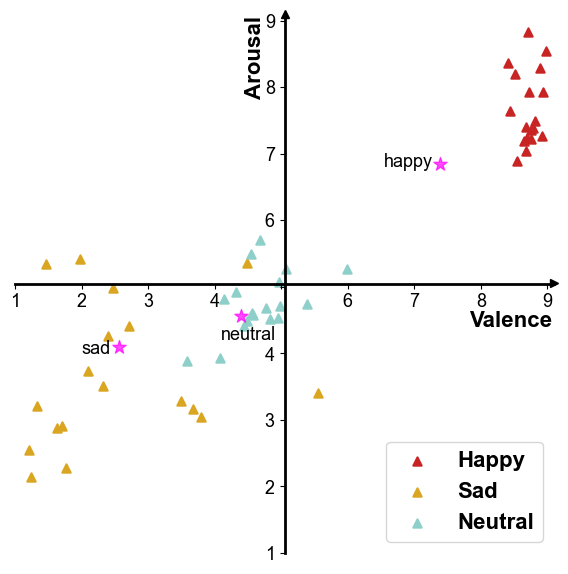

In [112]:
import matplotlib as mpl
# sns.set_style(style='whitegrid') 
fig, ax = plt.subplots(figsize=(7,7))

# Set bottom and left spines as x and y axes of coordinate system
ax.spines['bottom'].set_position('center')
ax.spines['left'].set_position('center')
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.setp(ax.spines.values(), linewidth=2)
# Draw arrows
arrow_fmt = dict(markersize=6, color='black', clip_on=False)
ax.plot((1), (5.05), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((5.05), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

# sc = ax.scatter(x = np.array(happy_va_mean)[:, 0], 
#                      y = np.array(happy_va_mean)[:, 1], 
#                      label='Happy', s=27, c='#c82423', edgecolors='k')

# sc = ax.scatter(x = np.array(sad_va_mean)[:, 0], 
#                      y = np.array(sad_va_mean)[:, 1], 
#                      label='Sad', s=27, c='goldenrod', edgecolors='k')

# sc = ax.scatter(x = np.array(neutral_va_mean)[:, 0], 
#                      y = np.array(neutral_va_mean)[:, 1], 
#                      label='Neutral', s=27, c='#8ECFC9', edgecolors='k')

sc = ax.scatter(x = np.array(happy_vae_mean).squeeze()[:, 0], 
                     y = np.array(happy_vae_mean).squeeze()[:, 1], 
                     label='Happy', marker='^', linewidths=1.5, c='#c82423')

sc = ax.scatter(x = np.array(sad_vae_mean).squeeze()[:, 0], 
                     y = np.array(sad_vae_mean).squeeze()[:, 1], 
                     label='Sad', marker='^', linewidths=1.5, c='goldenrod')

sc = ax.scatter(x = np.array(neutral_vae_mean).squeeze()[:, 0], 
                     y = np.array(neutral_vae_mean).squeeze()[:, 1], 
                     label='Neutral', marker='^', linewidths=1.5, c='#8ECFC9')

# reference ratings
weight_ref = [3/5, 2/5]
sad_ref = [weight_ref[0]*2.8+weight_ref[1]*2.2, weight_ref[0]*4.7+weight_ref[1]*3.2]
happy_ref = [weight_ref[0]*7.1+weight_ref[1]*7.8, weight_ref[0]*6.75+weight_ref[1]*7.0]
neutral_ref = [weight_ref[0]*4.5+weight_ref[1]*4.25, weight_ref[0]*4.8+weight_ref[1]*4.2]
sc = ax.scatter(x = [sad_ref[0], happy_ref[0], neutral_ref[0]], 
                     y = [sad_ref[1], happy_ref[1], neutral_ref[1]], 
                     marker='*', s=100, c='magenta', alpha=0.7)
# plt.axis('equal')
ax.set(xlim=(1, 9.1), ylim=(1, 9.1), aspect='equal')
# legend
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
ax.legend(prop={'family':'Arial', 'size':16, 'weight': 'bold'}, fancybox=True, ncol=1, loc='lower right')

# Create 'Valence' and 'Arousal' labels placed at the end of the axes
ax.set_xlabel('Valence', fontdict={'fontsize': 16, 'family':'Arial', 'weight': 'bold'}, labelpad=0, x=0.92)
ax.set_ylabel('Arousal', fontdict={'fontsize': 16, 'family':'Arial', 'weight': 'bold'}, labelpad=0, y=0.92, rotation=90)
# ax.set_title('MCMCPG', fontdict={'fontsize': 16, 'family':'Arial', 'weight': 'bold'}, loc='left')

ax.xaxis.set_ticks(np.arange(1, 10))
ax.set_xticklabels(['1', '2', '3', '4', '', '6', '7', '8', '9'], fontdict={'fontsize': 13, 'family':'Arial'})

ax.yaxis.set_ticks(np.arange(1, 10))
ax.set_yticklabels(['1', '2', '3', '4', '', '6', '7', '8', '9'], fontdict={'fontsize': 13, 'family':'Arial'})

# anotation
ax.text(2, 4.0, 'sad', color='k', verticalalignment='baseline', fontdict={'fontsize': 13, 'family':'Arial', 'weight': 'normal'})
ax.text(4.1, 4.2, 'neutral', color='k', verticalalignment='baseline', fontdict={'fontsize': 13, 'family':'Arial', 'weight': 'normal'})
ax.text(6.55, 6.8, 'happy', color='k', verticalalignment='baseline', fontdict={'fontsize': 13, 'family':'Arial', 'weight': 'normal'})

In [24]:
import scipy
def kl_mvn(to_mean, to_cov, fr_mean, fr_cov):
    """Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices"""
    m_to, S_to = to_mean, to_cov
    m_fr, S_fr = fr_mean, fr_cov
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2

# generate reference data
ref_va_mean = []
ref_va_cov = []

for i in range(23):
    samples = multivariate_normal.rvs(mean=[0, 0], cov=[[3, 0], [0, 3]], size=10, random_state=i)
    dist = Normal().fit(samples.astype(np.float32))
    ref_va_mean.append(dist.means.tolist())
    ref_va_cov.append(dist.covs.tolist())

kld_ref = []
kld_happy = []
kld_sad = []
kld_neutral = []
for i in range(23):
    for j in range(23):
        if i != j:
            kld = kl_mvn(np.array(ref_va_mean[i]), np.array(ref_va_cov[i]), np.array(ref_va_mean[j]), np.array(ref_va_cov[j]))
            kld_ref.append(kld)
            
            kld = kl_mvn(np.array(happy_va_mean[i]), np.array(happy_va_cov[i]), np.array(happy_va_mean[j]), np.array(happy_va_cov[j]))
            kld_happy.append(kld)
            kld = kl_mvn(np.array(sad_va_mean[i]), np.array(sad_va_cov[i]), np.array(sad_va_mean[j]), np.array(sad_va_cov[j]))
            kld_sad.append(kld)
            kld = kl_mvn(np.array(neutral_va_mean[i]), np.array(neutral_va_cov[i]), np.array(neutral_va_mean[j]), np.array(neutral_va_cov[j]))
            kld_neutral.append(kld)

# print(np.mean(kld_ref), np.mean(kld_happy), np.mean(kld_sad), np.mean(kld_neutral))
# len(kld_neutral)

groups = ['ref' for _ in range(506)] + ['happy' for _ in range(506)] + ['sad' for _ in range(506)] + ['neutral' for _ in range(506)]
data = kld_ref + kld_happy + kld_sad + kld_neutral
klds = pd.DataFrame()
klds['group'] = groups
klds['kld'] = data

ols_formula = 'kld ~ C(group)'
OLS = ols(formula = ols_formula, data = klds)
model = OLS.fit()
# model_results = model.summary()
# model_results
print(sm.stats.anova_lm(model, typ=2))

tukey_oneway = pairwise_tukeyhsd(endog = klds["kld"], 
                                 groups = klds["group"], 
                                 alpha=0.05)
print(tukey_oneway.summary())

                sum_sq      df          F        PR(>F)
C(group)    850.832930     3.0  32.277994  2.241696e-20
Residual  17748.753649  2020.0        NaN           NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  happy neutral  -1.2561    0.0 -1.7353 -0.7769   True
  happy     ref  -1.4534    0.0 -1.9326 -0.9742   True
  happy     sad  -0.1386 0.8794 -0.6177  0.3406  False
neutral     ref  -0.1973 0.7147 -0.6765  0.2819  False
neutral     sad   1.1175    0.0  0.6384  1.5967   True
    ref     sad   1.3148    0.0  0.8357   1.794   True
------------------------------------------------------


[Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0')]

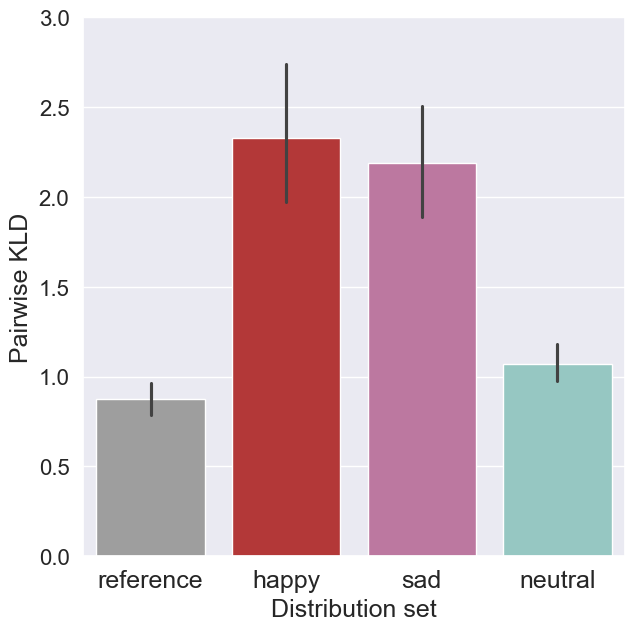

In [28]:
# visualization
fig, ax = plt.subplots(figsize=(7,7))
sc = sns.barplot(data=klds, x="group", y="kld", hue='group', ax=ax, legend=None, palette=sns.color_palette(["#9E9E9E", "#c82423", "#C76DA2", "#8ECFC9"]))
ax.set_ylim(0, 3)
# ax.legend(prop={'family':'Arial', 'size':16}, fancybox=True, ncol=1, loc='upper left')

ax.set_xlabel('Distribution set', fontdict={'fontsize': 18, 'family':'Arial'})
ax.set_ylabel('Pairwise KLD', fontdict={'fontsize': 18, 'family':'Arial'})
# ax.set_title('Intergroup comparison of Pairwise-KLD', fontdict={'fontsize': 16, 'family':'Arial'})

ax.xaxis.set_ticks(np.arange(0, 4))
ax.set_xticklabels(['reference', 'happy', 'sad', 'neutral'], fontdict={'fontsize': 18, 'family':'Arial'})
ax.yaxis.set_ticks(np.arange(0, 3.25, 0.5))
ax.set_yticklabels(np.arange(0, 3.25, 0.5), fontdict={'fontsize': 16, 'family':'Arial'})

[Text(0, 1, '1'),
 Text(0, 2, '2'),
 Text(0, 3, '3'),
 Text(0, 4, '4'),
 Text(0, 5, ''),
 Text(0, 6, '6'),
 Text(0, 7, '7'),
 Text(0, 8, '8'),
 Text(0, 9, '9')]

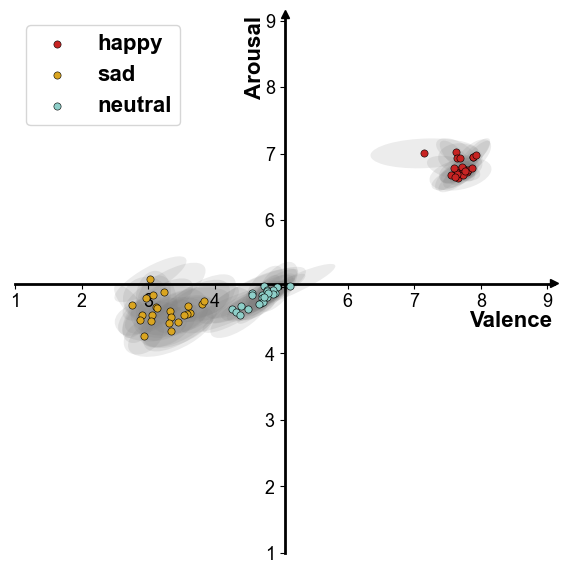

In [39]:
fig, ax = plt.subplots(figsize=(7,7))
# Set bottom and left spines as x and y axes of coordinate system
ax.spines['bottom'].set_position('center')
ax.spines['left'].set_position('center')
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.setp(ax.spines.values(), linewidth=2)
# Draw arrows
arrow_fmt = dict(markersize=6, color='black', clip_on=False)
ax.plot((1), (5.05), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((5.05), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

sc = sns.scatterplot(x = np.array(happy_va_mean)[:, 0], 
                     y = np.array(happy_va_mean)[:, 1], 
                     label='happy', s=27, c='#c82423', zorder=100, edgecolors='k', legend=False)
sc = sns.scatterplot(x = np.array(sad_va_mean)[:, 0], 
                     y = np.array(sad_va_mean)[:, 1], 
                     label='sad', s=27, c='goldenrod', zorder=100, edgecolors='k', legend=False)
sc = sns.scatterplot(x = np.array(neutral_va_mean)[:, 0], 
                     y = np.array(neutral_va_mean)[:, 1], 
                     label='neutral', s=27, c='#8ECFC9', zorder=100, edgecolors='k', legend=False)

for i in range(len(happy_va_mean)):
    confidence_ellipse_2(np.array(happy_va_mean[i]), np.array(happy_va_cov[i]), ax, n_std=1, facecolor='grey')
    confidence_ellipse_2(np.array(sad_va_mean[i]), np.array(sad_va_cov[i]), ax, n_std=1, facecolor='grey')
    confidence_ellipse_2(np.array(neutral_va_mean[i]), np.array(neutral_va_cov[i]), ax, n_std=1, facecolor='grey')

ax.set(xlim=(1, 9.1), ylim=(1, 9.1), aspect='equal')

ax.legend(prop={'family':'Arial', 'size':16, 'weight': 'bold'}, fancybox=True, ncol=1, loc='upper left')

# Create 'Valence' and 'Arousal' labels placed at the end of the axes
ax.set_xlabel('Valence', fontdict={'fontsize': 16, 'family':'Arial', 'weight': 'bold'}, labelpad=0, x=0.92)
ax.set_ylabel('Arousal', fontdict={'fontsize': 16, 'family':'Arial', 'weight': 'bold'}, labelpad=0, y=0.92, rotation=90)
# ax.set_title('MCMCPG', fontdict={'fontsize': 16, 'family':'Arial', 'weight': 'bold'}, loc='left')

ax.xaxis.set_ticks(np.arange(1, 10))
ax.set_xticklabels(['1', '2', '3', '4', '', '6', '7', '8', '9'], fontdict={'fontsize': 13, 'family':'Arial'})

ax.yaxis.set_ticks(np.arange(1, 10))
ax.set_yticklabels(['1', '2', '3', '4', '', '6', '7', '8', '9'], fontdict={'fontsize': 13, 'family':'Arial'})
# ax.set(xlim=(7.1, 8), ylim=(6.6, 7.1), aspect='equal')
# plt.axis('off')

In [ ]:
# bootstrapping comparing inter- and intra-individual Rhat
from utils import galmen_rubin
# load the original sample data
trace_vgmcp = np.load('secondary-data/samples_vgmcp.npy', allow_pickle='TRUE').item()
intra_rhat = {'happy':[], 'sad':[], 'neutral':[]}
inter_rhat = {'happy':[], 'sad':[], 'neutral':[]}

for emo in ['happy', 'sad', 'neutral']:
    for _ in range(1000):
        if np.random.randint(1, 24) <= 10:
            pid = np.random.choice([4, 5, 7, 8, 9, 11, 13, 15, 17, 19])
            rid1 = np.random.choice([4, 5, 7, 8, 9, 11, 13, 15, 17, 19])
            rid2 = np.random.choice([4, 5, 7, 8, 9, 11, 13, 15, 17, 19])
            chosen_1 = model(torch.tensor(trace_vgmcp[f'subject_{pid}_{emo}_1'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            chosen_2 = model(torch.tensor(trace_vgmcp[f'subject_{pid}_{emo}_2'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            random_1 = model(torch.tensor(trace_vgmcp[f'subject_{rid1}_{emo}_1'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            random_2 = model(torch.tensor(trace_vgmcp[f'subject_{rid2}_{emo}_2'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            intra_rhat[emo].append(galmen_rubin(chosen_1, chosen_2))
            inter_rhat[emo].append(galmen_rubin(random_1, random_2))
        else:
            pid = np.random.choice([1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28])
            rid1 = np.random.choice([1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28])
            rid2 = np.random.choice([1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28])
            chosen_1 = model(torch.tensor(trace_vgmcp[f'study2_subject_{pid}_{emo}_1'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            chosen_2 = model(torch.tensor(trace_vgmcp[f'study2_subject_{pid}_{emo}_2'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            random_1 = model(torch.tensor(trace_vgmcp[f'study2_subject_{rid1}_{emo}_1'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            random_2 = model(torch.tensor(trace_vgmcp[f'study2_subject_{rid2}_{emo}_2'], dtype=torch.float)).detach().cpu().numpy() *8 +1
            intra_rhat[emo].append(galmen_rubin(chosen_1, chosen_2))
            inter_rhat[emo].append(galmen_rubin(random_1, random_2))

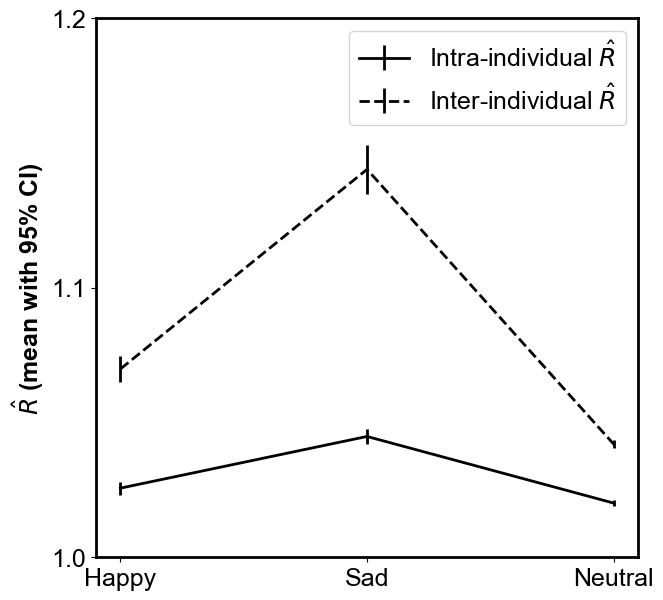

In [175]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rc('axes', linewidth=6)
ax.errorbar([0, 1, 2], [np.mean(intra_rhat['happy']), np.mean(intra_rhat['sad']), np.mean(intra_rhat['neutral'])], 
            yerr=[np.std(intra_rhat['happy'])*2, np.std(intra_rhat['sad'])*2, np.std(intra_rhat['neutral'])*2]/np.sqrt(1000), 
            label='Intra-individual $\hat{R}$', c='k', lw=2)
ax.errorbar([0, 1, 2], [np.mean(inter_rhat['happy']), np.mean(inter_rhat['sad']), np.mean(inter_rhat['neutral'])], 
            yerr=[np.std(inter_rhat['happy'])*2, np.std(inter_rhat['sad'])*2, np.std(inter_rhat['neutral'])]/np.sqrt(1000), 
            label='Inter-individual $\hat{R}$', ls='--', c='k', lw=2)
# setting ticks for x-axis 
ax.set_xticks([0, 1, 2])
# setting label for x tick
ax.set_xticklabels(['Happy', 'Sad', 'Neutral'], fontdict={'fontsize': 18, 'family':'Arial'})
# setting ticks for y-axis 
ax.set_yticks([1, 1.1, 1.2])
ax.set_yticklabels(['1.0', '1.1', '1.2'], fontdict={'fontsize': 18, 'family':'Arial'})
ax.set_ylabel('$\hat{R}$ (mean with 95% CI)', fontdict={'fontsize': 18, 'family':'Arial', 'weight': 'bold'})
ax.legend(prop={'family':'Arial', 'size':18}, fancybox=True)

            sum_sq     df          F        PR(>F)
C(group)  1.467260    2.0  97.530791  2.081485e-38
Residual  5.686658  756.0        NaN           NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
  happy neutral  -0.0334   0.0 -0.0515 -0.0153   True
  happy     sad   0.0719   0.0  0.0538  0.0901   True
neutral     sad   0.1054   0.0  0.0873  0.1235   True
-----------------------------------------------------


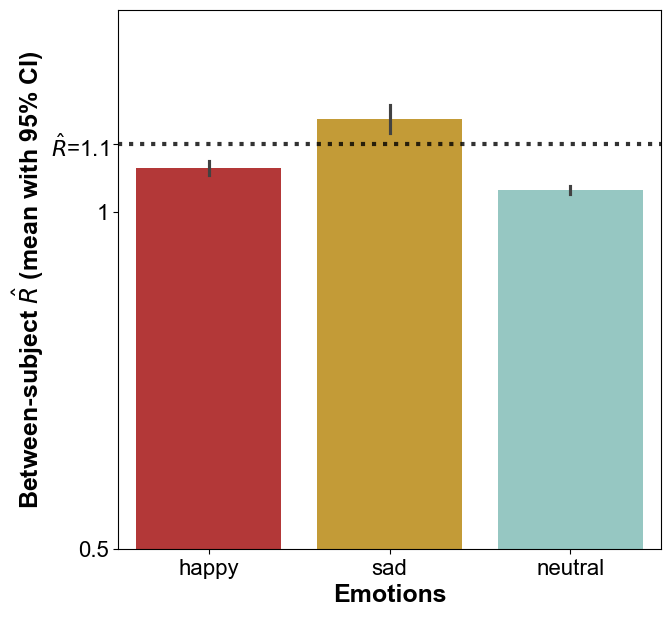

In [133]:
## inter-person Rhat in VA space
R_hat_happy_interperson = []
R_hat_sad_interperson = []
R_hat_neutral_interperson = []

happy_samples = [va_samples for key, va_samples in all_va_samples.items() if key.split('_')[-1] == 'happy']
sad_samples = [va_samples for key, va_samples in all_va_samples.items() if key.split('_')[-1] == 'sad']
neutral_samples = [va_samples for key, va_samples in all_va_samples.items() if key.split('_')[-1] == 'neutral']

for i in range(23):
    for j in range(i, 23):
        if i != j:
            R_hat_happy_interperson.append(galmen_rubin(happy_samples[i], happy_samples[j], method='identity'))
            R_hat_sad_interperson.append(galmen_rubin(sad_samples[i], sad_samples[j], method='identity'))
            R_hat_neutral_interperson.append(galmen_rubin(neutral_samples[i], neutral_samples[j], method='identity'))


groups = ['happy' for _ in range(len(R_hat_happy_interperson))] + ['sad' for _ in range(len(R_hat_sad_interperson))] + ['neutral' for _ in range(len(R_hat_neutral_interperson))]
data = R_hat_happy_interperson + R_hat_sad_interperson + R_hat_neutral_interperson
Rhats = pd.DataFrame()
Rhats['group'] = groups
Rhats['rhats'] = data
# visualization
fig, ax = plt.subplots(figsize=(7,7))
sc = sns.barplot(data=Rhats, x="group", y="rhats", hue='group', ax=ax, palette=sns.color_palette(["#c82423", "goldenrod", "#8ECFC9"]), errorbar=('ci', 99))
ax.set_ylim(0.5, 1.3)
# ax.legend(prop={'family':'Arial', 'size':18}, fancybox=True, ncol=1, loc='upper left')

ax.set_xlabel('Emotions', fontdict={'fontsize': 18, 'family':'Arial', 'weight': 'bold'})
ax.set_ylabel('Between-subject $\hat{R}$ (mean with 95% CI)', fontdict={'fontsize': 18, 'family':'Arial', 'weight': 'bold'})
# ax.set_title('Between-subject $\hat{R}$ in each facial affect', fontdict={'fontsize': 16, 'family':'Arial'})

ax.xaxis.set_ticks(np.arange(0, 3))
ax.set_xticklabels(['happy', 'sad', 'neutral'], fontdict={'fontsize': 16, 'family':'Arial'})
ax.yaxis.set_ticks([0.5, 1, 1.1])
ax.set_yticklabels([0.5, 1, '$\hat{R}$=1.1'], fontdict={'fontsize': 16, 'family':'Arial'})

plt.axhline(y=1.1, linestyle='dotted', c='k', alpha=0.8, linewidth=3) 

ols_formula = 'rhats ~ C(group)'
OLS = ols(formula = ols_formula, data = Rhats)
model = OLS.fit()
# model_results = model.summary()
# model_results
print(sm.stats.anova_lm(model, typ=2))

tukey_oneway = pairwise_tukeyhsd(endog = Rhats["rhats"], 
                                 groups = Rhats["group"], 
                                 alpha=0.05)
print(tukey_oneway.summary())

In [567]:
stats.ttest_1samp(Rhats[Rhats['group']=='sad']['rhats'], popmean=1.1)

TtestResult(statistic=4.579330134887611, pvalue=7.335648064342627e-06, df=252)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
sc = sns.scatterplot(x = np.mean(happy_sample_va[:, 0, :], axis=0), 
                     y = np.mean(happy_sample_va[:, 1, :], axis=0), 
                     label='happy')
sc = sns.scatterplot(x = np.mean(happy_sample_va[:, 0, [3, 9, 11, 21]], axis=0), 
                     y = np.mean(happy_sample_va[:, 1, [3, 9, 11, 21]], axis=0), 
                     label='happy-1')
for i in range(23):
    if i % 3 == 0:
        confidence_ellipse(happy_sample_va[:, 0, i], happy_sample_va[:, 1, i], ax, n_std=1, alpha=0.15)

sc = sns.scatterplot(x = np.mean(sad_sample_va[:, 0, :], axis=0), 
                     y = np.mean(sad_sample_va[:, 1, :], axis=0), 
                     label='sad')
sc = sns.scatterplot(x = np.mean(sad_sample_va[:, 0, [0, 3, 6, 7, 8, 13, 17, 19, 20]], axis=0), 
                     y = np.mean(sad_sample_va[:, 1, [0, 3, 6, 7, 8, 13, 17, 19, 20]], axis=0), 
                     label='sad-1')
for i in range(23):
    if i % 3 == 0:
        # confidence_ellipse(sad_sample_va[:, 0, i], sad_sample_va[:, 1, i], ax, edgecolor='red')
        confidence_ellipse(sad_sample_va[:, 0, i], sad_sample_va[:, 1, i], ax, n_std=1, alpha=0.15)

sc = sns.scatterplot(x = np.mean(neutral_sample_va[:, 0, :], axis=0), 
                     y = np.mean(neutral_sample_va[:, 1, :], axis=0), 
                     label='netral')
for i in range(23):
    if i % 3 == 0:
        # confidence_ellipse(neutral_sample_va[:, 0, i], neutral_sample_va[:, 1, i], ax, edgecolor='red')
        confidence_ellipse(neutral_sample_va[:, 0, i], neutral_sample_va[:, 1, i], ax, n_std=1, alpha=0.15)

# plt.axis('equal')
ax.set_xlim(1, 9)
ax.set_ylim(1, 9)
ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
# legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [8]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=2, facecolor='grey', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x*2, height=ell_radius_y*2,
                      facecolor=facecolor, lw=1, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # print(scale_x)
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def confidence_ellipse_2(mean, cov, ax, n_std=2, facecolor='grey', **kwargs):
    cov = cov
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x*2, height=ell_radius_y*2,
                      facecolor=facecolor, alpha=0.15, lw=1, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # print(scale_x)
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [9]:
# Define mean and covariance matrix for your bivariate normal distribution
def confidence_95(x, y, ax, n_std=1):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mean = np.array([mean_x, mean_y])  # Replace with your actual mean
    cov_matrix = np.cov(x, y)  # Replace with your actual covariance matrix
    
    # Generate points for the confidence ellipse
    n_points = 100
    angles = np.linspace(0, 2 * np.pi, n_points)
    xy = np.column_stack((np.cos(angles), np.sin(angles)))
    points = mean + np.dot(xy, np.linalg.cholesky(cov_matrix*1.5).T) * n_std
    
    # Plot the confidence ellipse
    ax.plot(points[:, 0], points[:, 1], color='red')
    # ax.scatter(x, y, alpha=0.5, label='Data points')  # Scatter plot of your data

In [450]:
x, y = neutral_sample_va[:, 0, 0], neutral_sample_va[:, 1, 0]

In [451]:
mean_x = np.mean(x)
mean_y = np.mean(y)
mean = np.array([mean_x, mean_y])
mean

array([4.70903897, 4.79559616])

In [452]:
cov_matrix = np.cov(x, y)
cov_matrix

array([[0.38867738, 0.16375945],
       [0.16375945, 0.09219817]])

In [453]:
angles = np.linspace(0, 2 * np.pi, 20)
angles

array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
       1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
       3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
       4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531])

In [454]:
xy = np.column_stack((np.cos(angles), np.sin(angles)))
xy

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 9.45817242e-01,  3.24699469e-01],
       [ 7.89140509e-01,  6.14212713e-01],
       [ 5.46948158e-01,  8.37166478e-01],
       [ 2.45485487e-01,  9.69400266e-01],
       [-8.25793455e-02,  9.96584493e-01],
       [-4.01695425e-01,  9.15773327e-01],
       [-6.77281572e-01,  7.35723911e-01],
       [-8.79473751e-01,  4.75947393e-01],
       [-9.86361303e-01,  1.64594590e-01],
       [-9.86361303e-01, -1.64594590e-01],
       [-8.79473751e-01, -4.75947393e-01],
       [-6.77281572e-01, -7.35723911e-01],
       [-4.01695425e-01, -9.15773327e-01],
       [-8.25793455e-02, -9.96584493e-01],
       [ 2.45485487e-01, -9.69400266e-01],
       [ 5.46948158e-01, -8.37166478e-01],
       [ 7.89140509e-01, -6.14212713e-01],
       [ 9.45817242e-01, -3.24699469e-01],
       [ 1.00000000e+00, -2.44929360e-16]])

In [455]:
np.linalg.cholesky(cov_matrix).T

array([[0.62343996, 0.26267076],
       [0.        , 0.1523228 ]])